In [1]:
import cox
from cox.readers import CollectionReader
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# constants 
BASE_CLASSIFIER = '/home/gridsan/stefanou/cifar-10/resnet-18/base_classifier_noised_again'
LOGIT_BALL_CLASSIFIER = '/home/gridsan/stefanou/cifar-10/resnet-18/truncated_ce_classifier_noised_again'
STANDARD_CLASSIFIER = '/home/gridsan/stefanou/cifar-10/resnet-18/standard_classifier_noised_again'

In [119]:
def plot(logs, metadata, class_): 
    plt.figure(figsize=(15, 10))
    # iterate over learning rates
    for i, lr in enumerate(np.sort(metadata.lr.unique())): 
        lr_logs = logs[logs.exp_id.isin(metadata[metadata.lr.isin([lr])].exp_id)]

        plt.subplot(2, 5, i+1, label='loss')
        sns.lineplot(data=lr_logs, x='epoch', y='train_loss', label='{} train loss'.format(class_))
        sns.lineplot(data=lr_logs, x='epoch', y='val_loss', label='{} val loss'.format(class_))
        plt.title('{} Loss: lr - {}'.format(class_, lr))
        plt.xlabel('Epoch')
        plt.ylabel('CE Loss')

        plt.subplot(2, 5, i+6, label='acc')
        sns.lineplot(data=lr_logs, x='epoch', y='train_prec1', label='{} train prec1'.format(class_))
        sns.lineplot(data=lr_logs, x='epoch', y='val_prec1', label='{} val prec1'.format(class_))
        plt.title('Prec1: lr - {}'.format(class_, lr))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
    plt.show()

In [120]:
base_reader = CollectionReader(BASE_CLASSIFIER)
base_logs = base_reader.df('logs')
base_metadata = base_reader.df('metadata')
unseen = base_reader.df('unseen')
test = base_reader.df('test')
trunc_train = base_reader.df('trunc_train')
train_base = base_reader.df('train_base')
base_reader.close()

trunc_reader = CollectionReader(LOGIT_BALL_CLASSIFIER)
trunc_logs = trunc_reader.df('logs')
trunc_metadata = trunc_reader.df('metadata')
trunc_unseen = trunc_reader.df('unseen')
trunc_test = trunc_reader.df('test')
trunc_trunc_train = trunc_reader.df('trunc_train')
trunc_train_base = trunc_reader.df('train_base')
trunc_reader.close()

standard_reader = CollectionReader(STANDARD_CLASSIFIER)
standard_logs = standard_reader.df('logs')
standard_metadata = standard_reader.df('metadata')
standard_unseen = standard_reader.df('unseen')
standard_test = standard_reader.df('test')
standard_trunc_train = standard_reader.df('trunc_train')
standard_train_base = standard_reader.df('train_base')
standard_reader.close()

100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


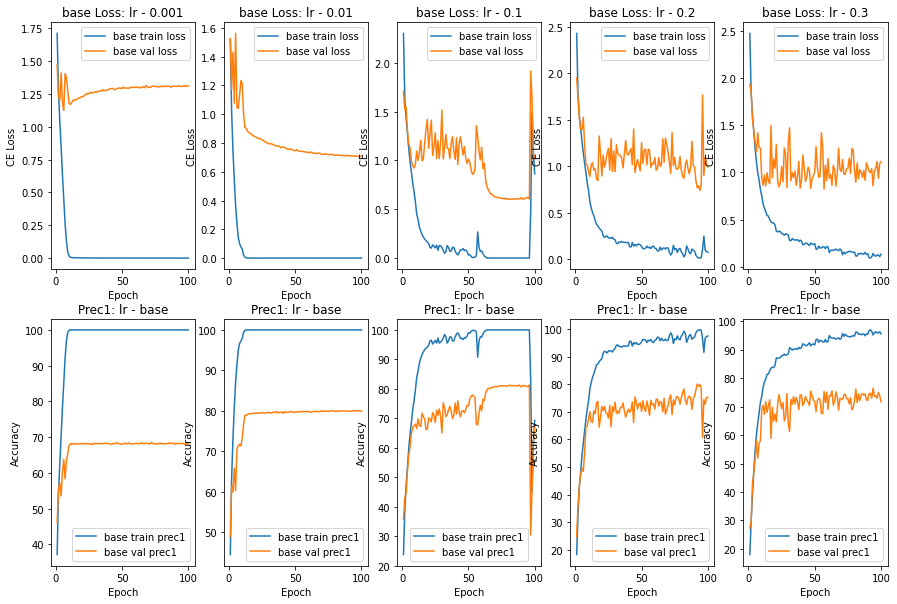

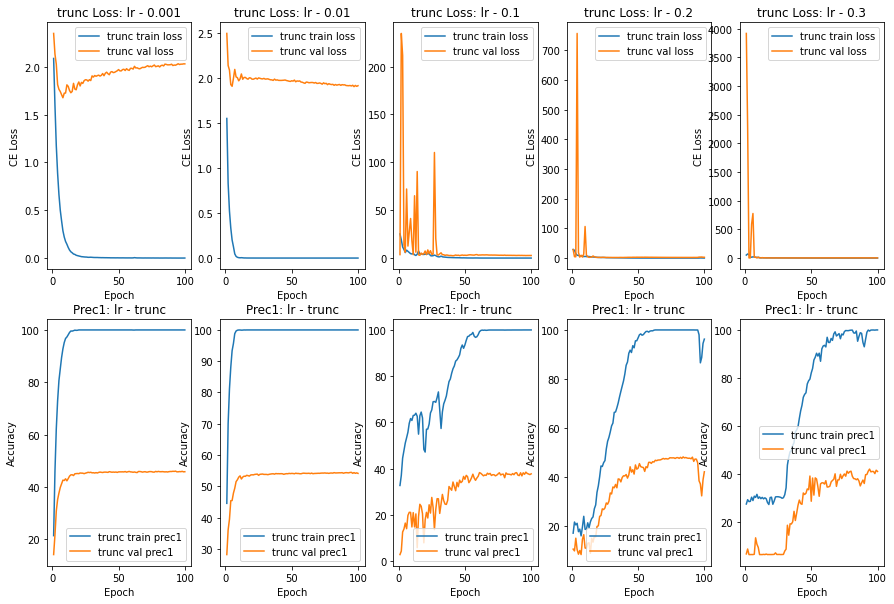

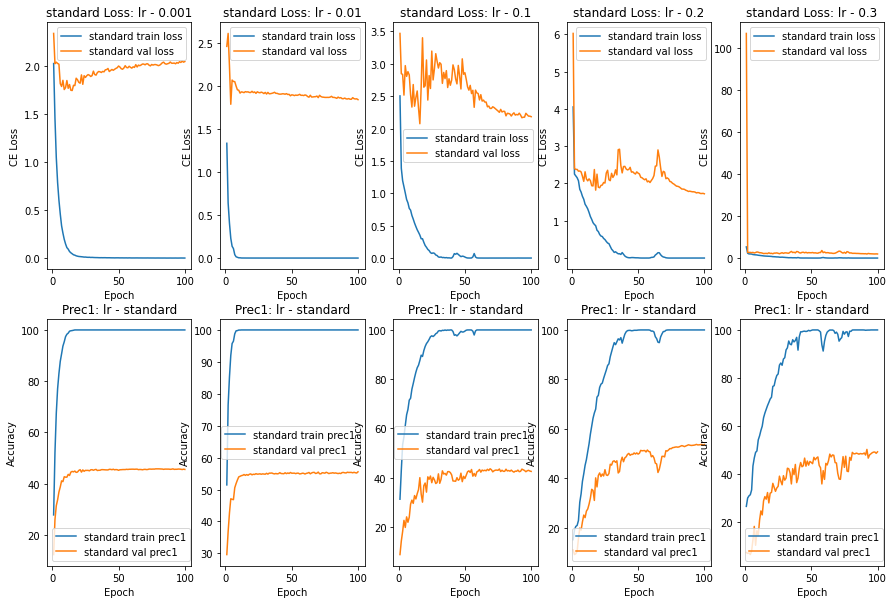

In [121]:
plot(base_logs, base_metadata, 'base')
plot(trunc_logs, trunc_metadata, 'trunc')
plot(standard_logs, standard_metadata, 'standard')

Text(0, 0.5, 'Accuracy')

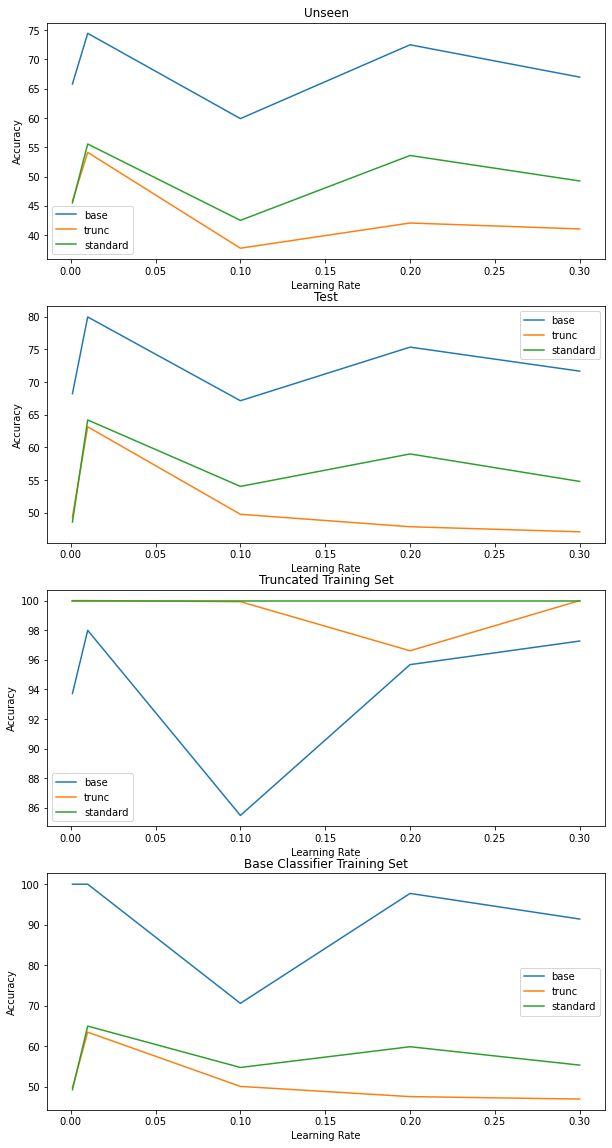

In [122]:
plt.figure(figsize=(10, 20))

# iterate over learning rates
def filter_(metadata, unseen, test, trunc_train, train_base):
    # iterate over learning rates
    for i, lr in enumerate(metadata.lr.unique()): 
        # experiment ids
        exp_ids = metadata[metadata.lr.isin([lr])].exp_id

        # use .apply() to find exp id for every experiment                       
        unseen['lr'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        test['lr'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        trunc_train['lr'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
        train_base['lr'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
    return unseen, test, trunc_train, train_base


unseen_, test_, trunc_train_, train_base_ = filter_(base_metadata, unseen, test, trunc_train, train_base)
trunc_unseen_, trunc_test_, trunc_trunc_train_, trunc_train_base_ = filter_(trunc_metadata, trunc_unseen, trunc_test, trunc_trunc_train, trunc_train_base)
standard_unseen_, standard_test_, standard_trunc_train_, standard_train_base_ = filter_(standard_metadata, standard_unseen, standard_test, standard_trunc_train, standard_train_base)

    
plt.subplot(4, 1, 1)
sns.lineplot(x='lr', y='test_prec1', data=unseen_, label='base')
sns.lineplot(x='lr', y='test_prec1', data=trunc_unseen_, label='trunc')
sns.lineplot(x='lr', y='test_prec1', data=standard_unseen_, label='standard')
plt.title('Unseen')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')


plt.subplot(4, 1, 2)
sns.lineplot(x='lr', y='test_prec1', data=test_, label='base')
sns.lineplot(x='lr', y='test_prec1', data=trunc_test_, label='trunc')
sns.lineplot(x='lr', y='test_prec1', data=standard_test_, label='standard')
plt.title('Test')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

plt.subplot(4, 1, 3)
sns.lineplot(x='lr', y='test_prec1', data=trunc_train_, label='base')
sns.lineplot(x='lr', y='test_prec1', data=trunc_trunc_train_, label='trunc')
sns.lineplot(x='lr', y='test_prec1', data=standard_trunc_train_, label='standard')
plt.title('Truncated Training Set')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

plt.subplot(4, 1, 4)
sns.lineplot(x='lr', y='test_prec1', data=train_base_, label='base')
sns.lineplot(x='lr', y='test_prec1', data=trunc_train_base_, label='trunc')
sns.lineplot(x='lr', y='test_prec1', data=standard_train_base_, label='standard')
plt.title('Base Classifier Training Set')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')